<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Train-test Split and Cross-Validation Lab

_Authors: Joseph Nelson (DC), Kiefer Katovich (SF)_

---

## Review of train/test validation methods

We've discussed overfitting, underfitting, and how to validate the "generalizeability" of your models by testing them on unseen data. 

In this lab you'll practice two related validation methods: 
1. **train/test split**
2. **k-fold cross-validation**

Train/test split and k-fold cross-validation both serve two useful purposes:
- We prevent overfitting by not using all the data, and
- We retain some remaining data to evaluate our model.

In the case of cross-validation, the model fitting and evaluation is performed multiple times on different train/test splits of the data.

Ultimately we can the training and testing validation framework to compare multiple models on the same dataset. This could be comparisons of two linear models, or of completely different models on the same data.


## Instructions

For your independent practice, fit **three different models** on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model that you like. 

**Start with train/test split validation:**
* Fix a testing/training split of the data
* Train each of your models on the training data
* Evaluate each of the models on the test data
* Rank the models by how well they score on the testing data set.

**Then try K-Fold cross-validation:**
* Perform a k-fold cross validation and use the cross-validation scores to compare your models. Did this change your rankings?
* Try a few different K-splits of the data for the same models.

If you're interested, try a variety of response variables.  We start with **MEDV** (the `.target` attribute from the dataset load method).

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import patsy
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from yellowbrick.regressor import PredictionError, ResidualsPlot


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')


### Data:

Import data <code>boston_data</code> from the <code>dataset</code> folder.

**Data Dictionary:**
|Variable|Description|
|---|---|
|CRIM|per capita crime rate by town|
|ZN|proportion of residential land zoned for lots over 25,000 sq.ft.|
|INDUS|proportion of non-retail business acres per town|
|CHAS| Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|NOX|  nitric oxides concentration (parts per 10 million)|
|RM|   average number of rooms per dwelling|
|AGE|  proportion of owner-occupied units built prior to 1940|
|DIS|  weighted distances to five Boston employment centres|
|RAD|  index of accessibility to radial highways|
|TAX|  full-value property-tax rate per &dollar;10,000|
|PTRATIO|  pupil-teacher ratio by town|
|B|1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town|
|LSTAT|% lower status of the population|
|MEDV| Median value of owner-occupied homes in &dollar;1000's|

Your target variable is <code>MEDV</code>.

In [2]:
#Import data boston_data from the dataset folder.
df = pd.read_csv("../03_02-lab-cross_validation_regularization-regression/datasets/boston_data.csv")

### 1. Clean up any data problems

Load the Boston housing data.  Fix any problems, if applicable.

In [3]:
# Print first 5 rows
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# Check shape of data
df.shape

(506, 14)

In [5]:
# Check summary statistics
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
# Check for missing values
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [7]:
#Check for duplicates
df.duplicated().sum()

0

In [8]:
# Check data types
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

### 2. Select 3-4 variables with your dataset to perform a 50/50 test train split on

- Use sklearn.
- Obtain Train Score and Test Score, and interpret your model's performance.
    - is the model underfitting?
    - is the model overfitting?
- Use `seaborn jointplot` to plot your predictions against the true value.
    - You may refer to this [seaborn document](https://seaborn.pydata.org/generated/seaborn.jointplot.html)

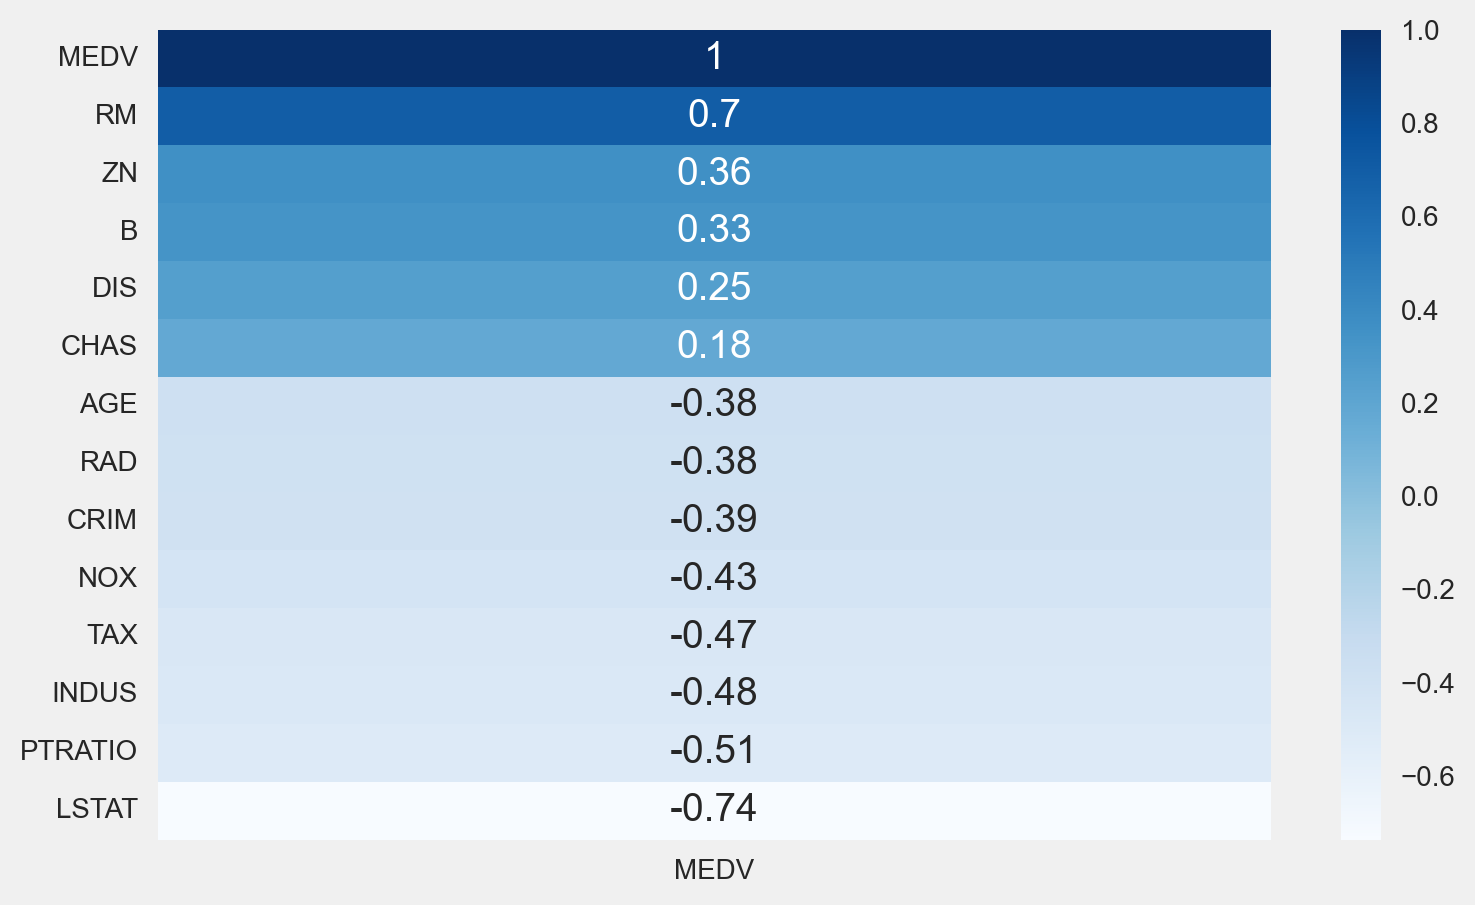

In [9]:
# Create a heatmap arranged by features that are correlated with MEDV, to select for features for input into our model
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr()[['MEDV']].sort_values('MEDV', ascending=False), annot=True, cmap='Blues');

**Comment here**<br>
I will choose the features RM, LSTAT, CRIM and DIS for my first model. Although I feel that a linear model will work best with features that are highly correlated (since pearson measures linear correlations), I have chosen CRIM and DIS as those 2 make intuitive sense to me being a predictor of housing prices, at the risk of some underfitting. I do so with the knowledge that I can always use a more flexible model with these chosen features to better capture the inherent signal.

In [10]:
# Choose our features for our first model
features = ['DIS', 'RM', 'CRIM', 'LSTAT']
# Create our features matrix
X = df[features]
# Create our target series
y = df['MEDV']

In [11]:
#Train-test-split with 50/50 train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [12]:
# Check shapes of train/test splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253, 4) (253, 4) (253,) (253,)


In [13]:
# Instantiate the model.
model = LinearRegression()

# Fit the model on the training data.
model.fit(X_train, y_train)


LinearRegression()

In [14]:
print(f'The R^2 for the training set with a 50/50 train-test split is: {model.score(X_train, y_train)}')
print(f'The R^2 for the test set with a 50/50 train-test split is: {model.score(X_test, y_test)}')

The R^2 for the training set with a 50/50 train-test split is: 0.6851099293321598
The R^2 for the test set with a 50/50 train-test split is: 0.6259552185979789


**Comment here**<br>
I don't feel it's fair to state whether a model is overfit or underfit without some other model to compare to. But for the purpose of answering the question, let's go with overfit, since the performance (R^2 values) between training and test are quite different, about 0.06.


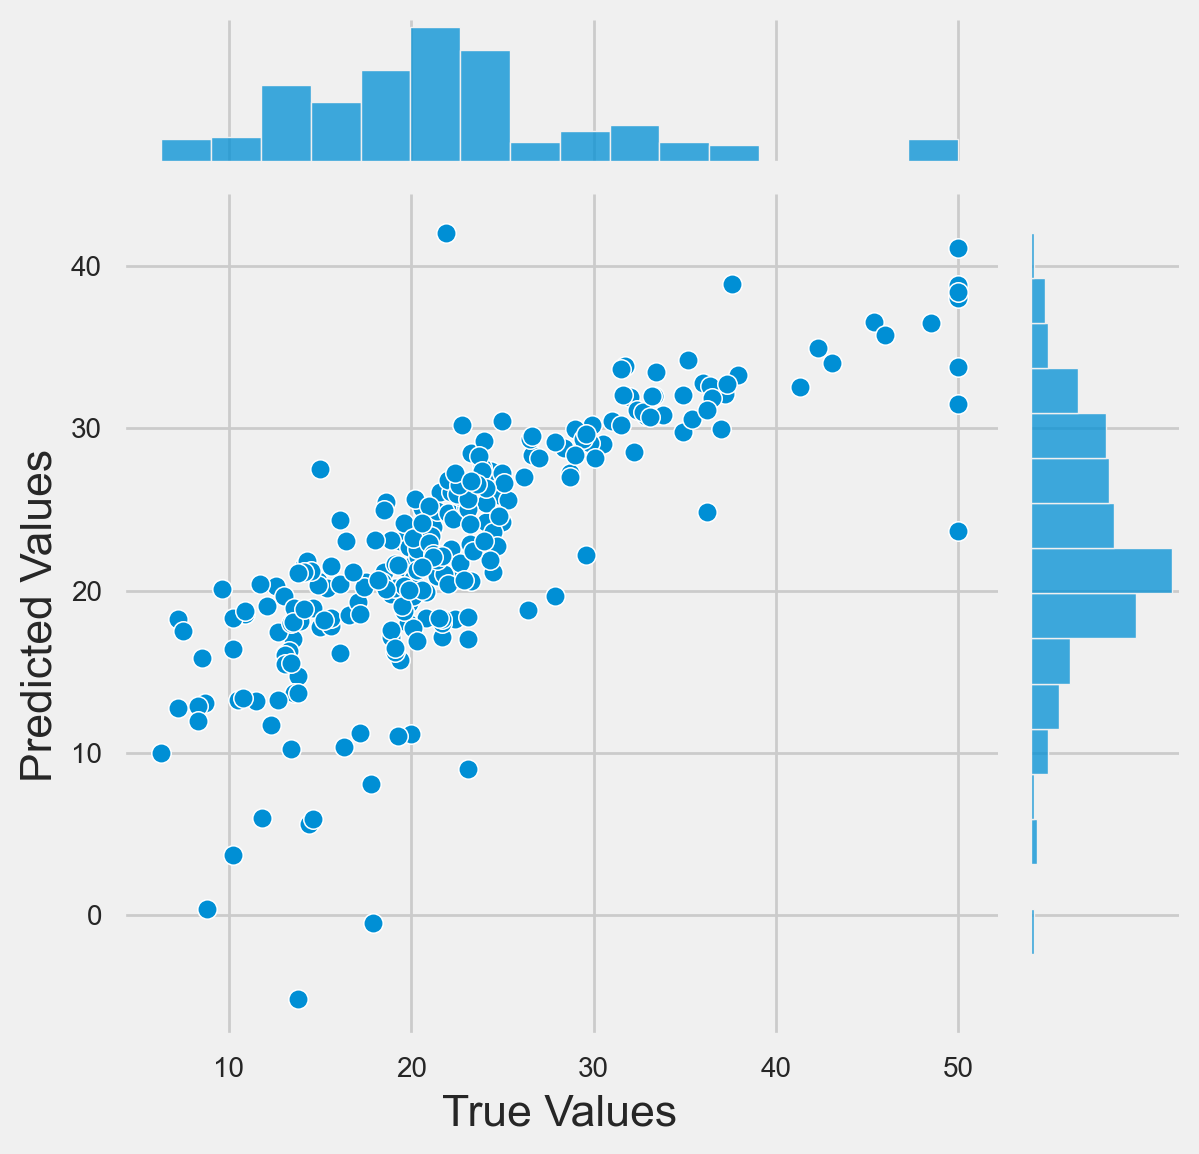

In [15]:
# Generate predictions
y_pred = model.predict(X_test)

#plot y_predict vs y_test (your y true values)
sns.jointplot(x=y_test, y=y_pred)
plt.ylabel('Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 16);

**Comment here**<br>

Yellowbrick can recreate the same plot as above but does so with a best-fit and identity line which allows one to better see the prediction error (which seems to be the point of the question). For a perfect model these points would line up in a 45-degree line. Our model seems to predict lower values for the high end of y.

C:\Users\Wes\mambaforge\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


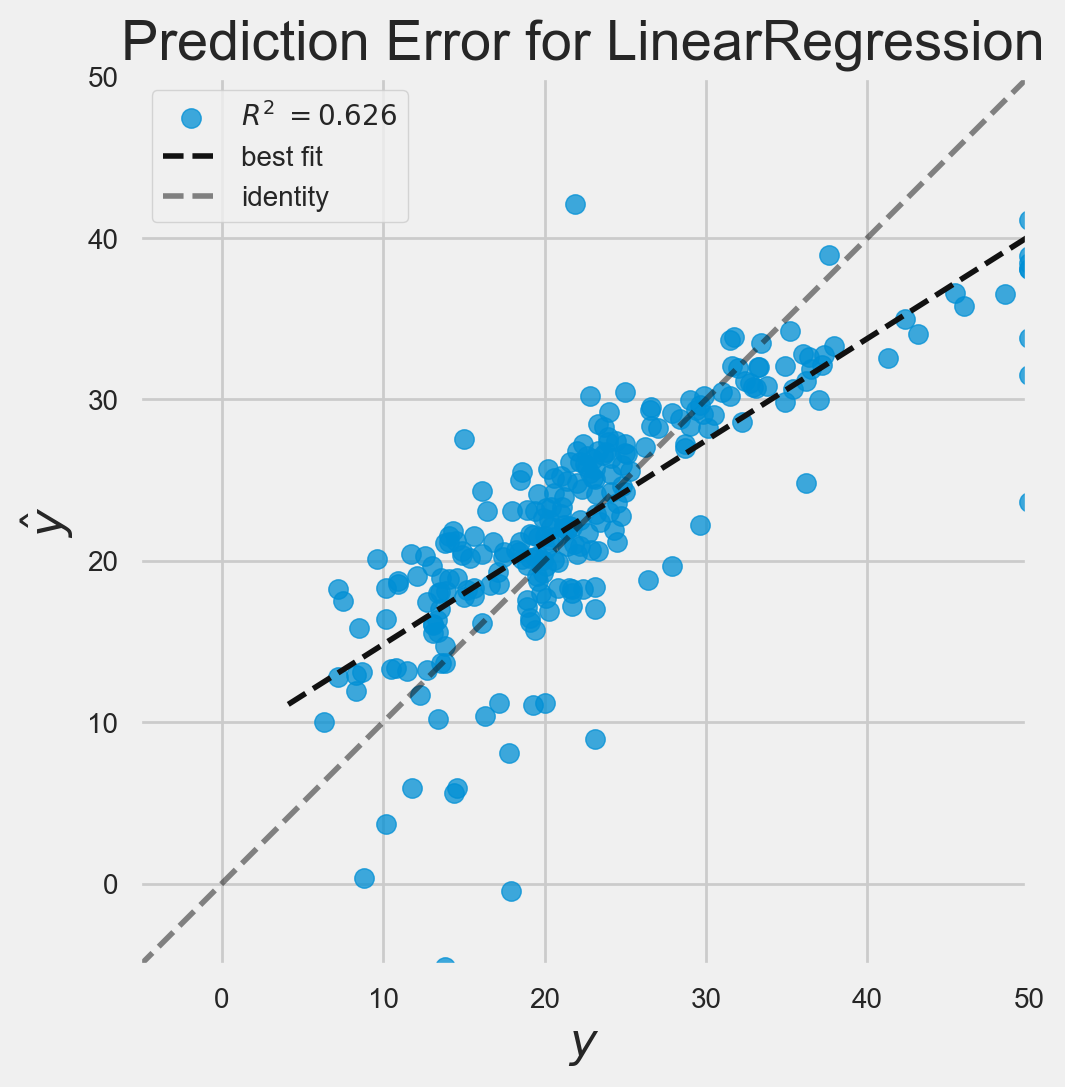

In [16]:
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof();

### 3. Try 70/30 and 90/10
- Score and plot.  
- How do your metrics change?

In [17]:
#Train-test-split with 70/30 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Instantiate the model.
model = LinearRegression()

# Fit the model on the training data.
model.fit(X_train, y_train)

print(f'The R^2 for the training set with a 70/30 train-test split is: {model.score(X_train, y_train)}')
print(f'The R^2 for the test set with a 70/30 train-test split is: {model.score(X_test, y_test)}')

The R^2 for the training set with a 70/30 train-test split is: 0.7016552117247707
The R^2 for the test set with a 70/30 train-test split is: 0.5357339683795832


**Comment here**<br>
Now, when comparing to the 50/50 split, the model's performance on the training set has improved from 0.685 to 0.701. We can infer that the greater availability of training data has allowed our model to 'learn' more of the signal from the data. Unfortunately, the model's performance on the test set has deproved from 0.625 to 0.535. We can likely conclude that comparing our 2 models, this current one has overfitted to the training data, relative to the earlier 50/50 split model. I make this conclusion on the basis that our performance has diverged between the training and test set, which is a sign of model overfit.


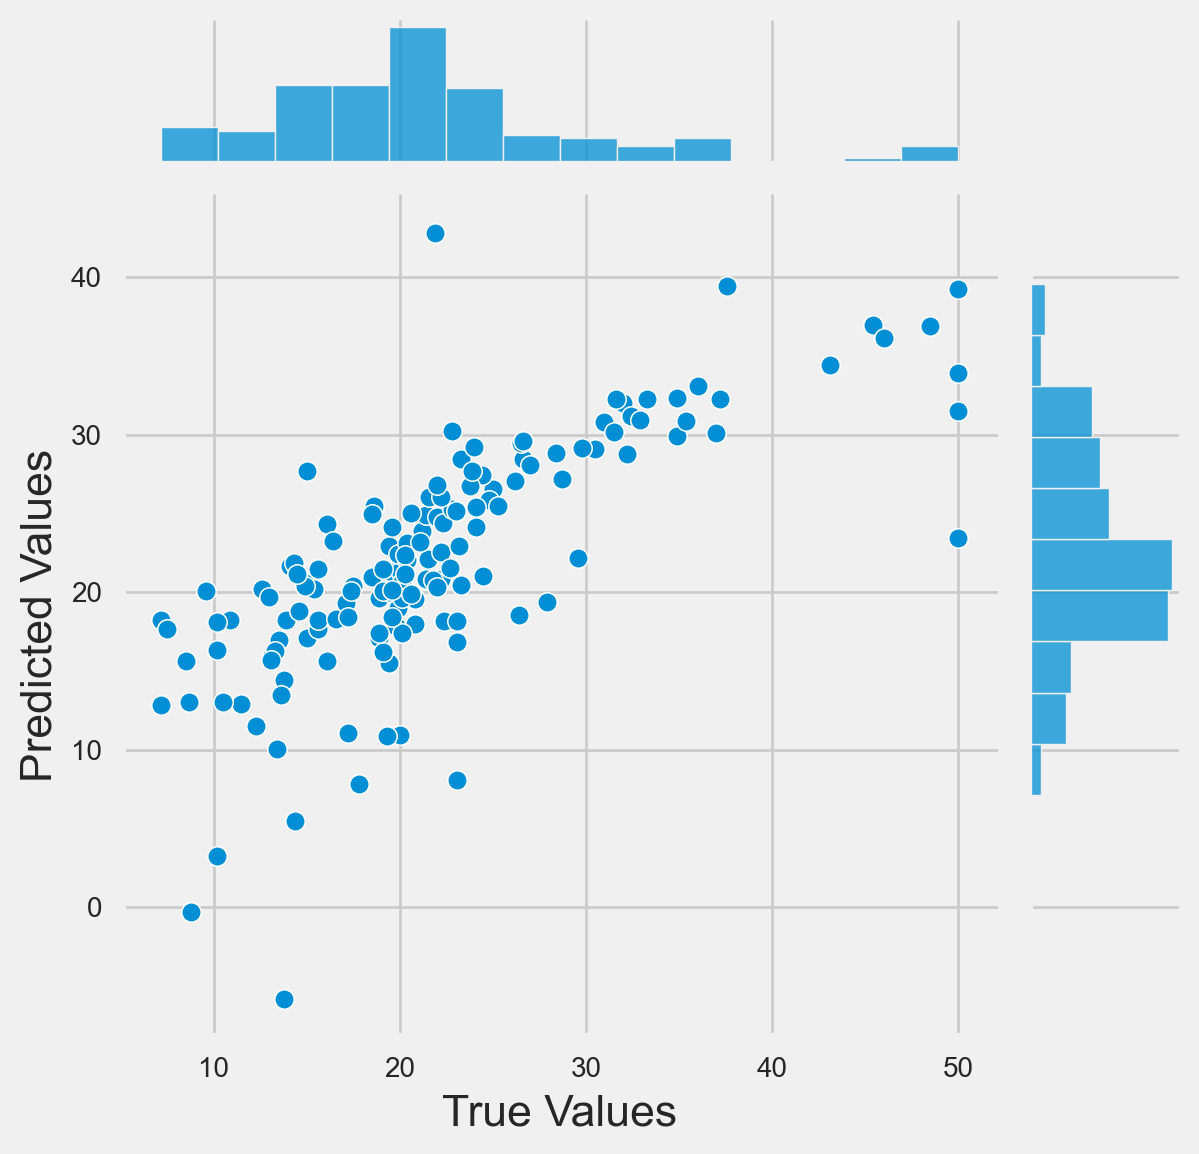

In [18]:
#Generate predictions.
y_pred = model.predict(X_test)

#plot y_predict vs y_test (your y true values)
sns.jointplot(x=y_test, y=y_pred)
plt.ylabel('Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 16);

C:\Users\Wes\mambaforge\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


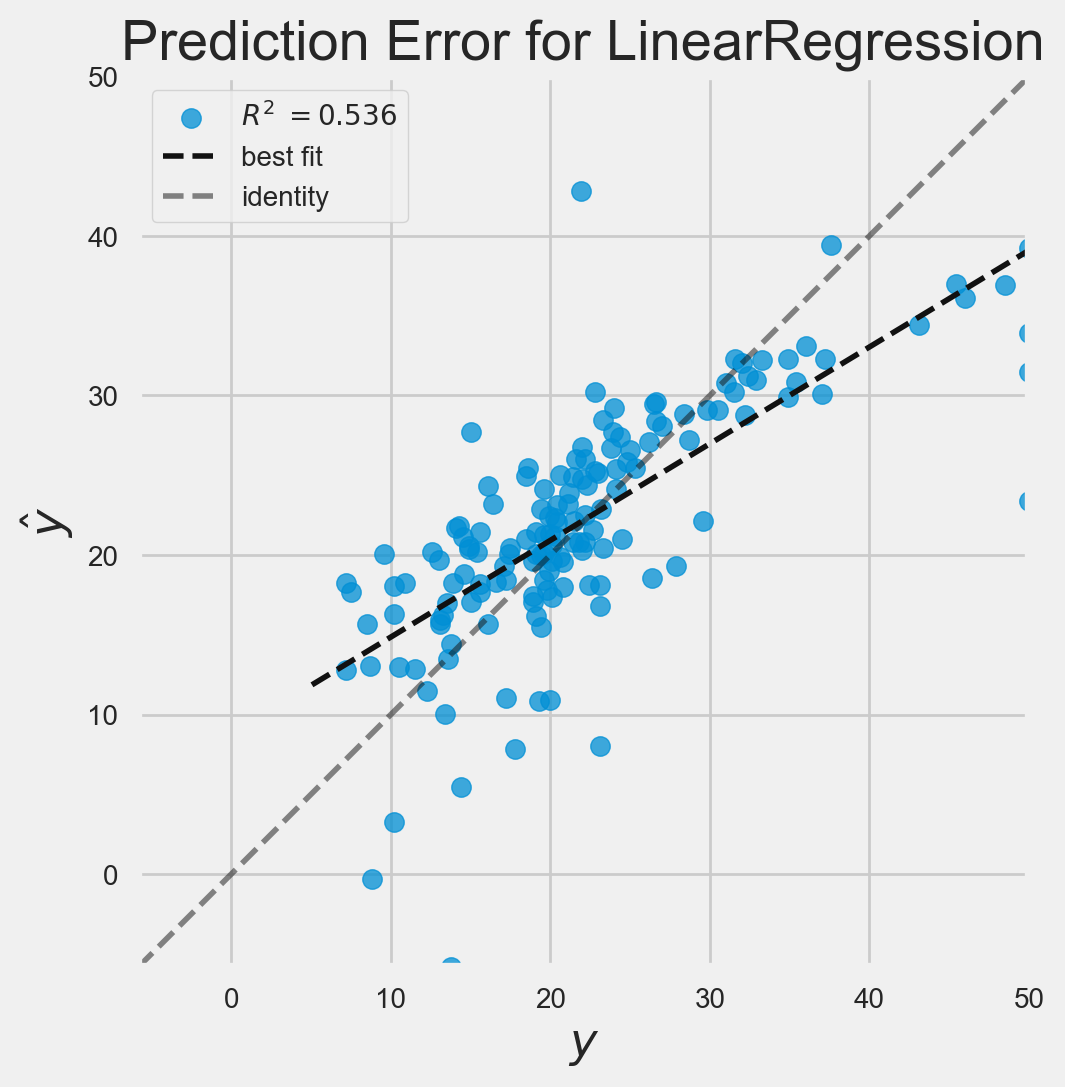

In [19]:
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof();

**Comment here**<br>

Recreating the prediction error plot using yellowbrick, we see a similar problem with the 50/50 split but with more variance on the test set as indicated by the lower R2 value.

### 90/10 split

In [20]:
#Train-test-split with 90/10 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# Instantiate the model.
model = LinearRegression()

# Fit the model on the training data.
model.fit(X_train, y_train)

print(f'The R^2 for the training set with a 90/10 train-test split is: {model.score(X_train, y_train)}')
print(f'The R^2 for the test set with a 90/10 train-test split is: {model.score(X_test, y_test)}')

The R^2 for the training set with a 90/10 train-test split is: 0.6730466768334123
The R^2 for the test set with a 90/10 train-test split is: 0.5346268695101035


**Comment here**<br>

Further increasing the train/test split to 90/10 has resulted in some interesting results. The model's performance on the training set has decreased slightly from 0.701 to 0.673, where the model's performance on the test set has remained about the same (0.535 to 0.534). I will conclude that the model has more than enough data to learn from with a training split of 70%, and that using 90% of the data to train on did not improve model's performance, in fact if anything, the performance has decreased. 

Furthermore, when comparing the 70/30 and 90/10 train-test split models, even with more data to train on, the model has not been able to generalise better to the test set. In this case, I would suggest changing the features to train on or using a different model architecture altogether.


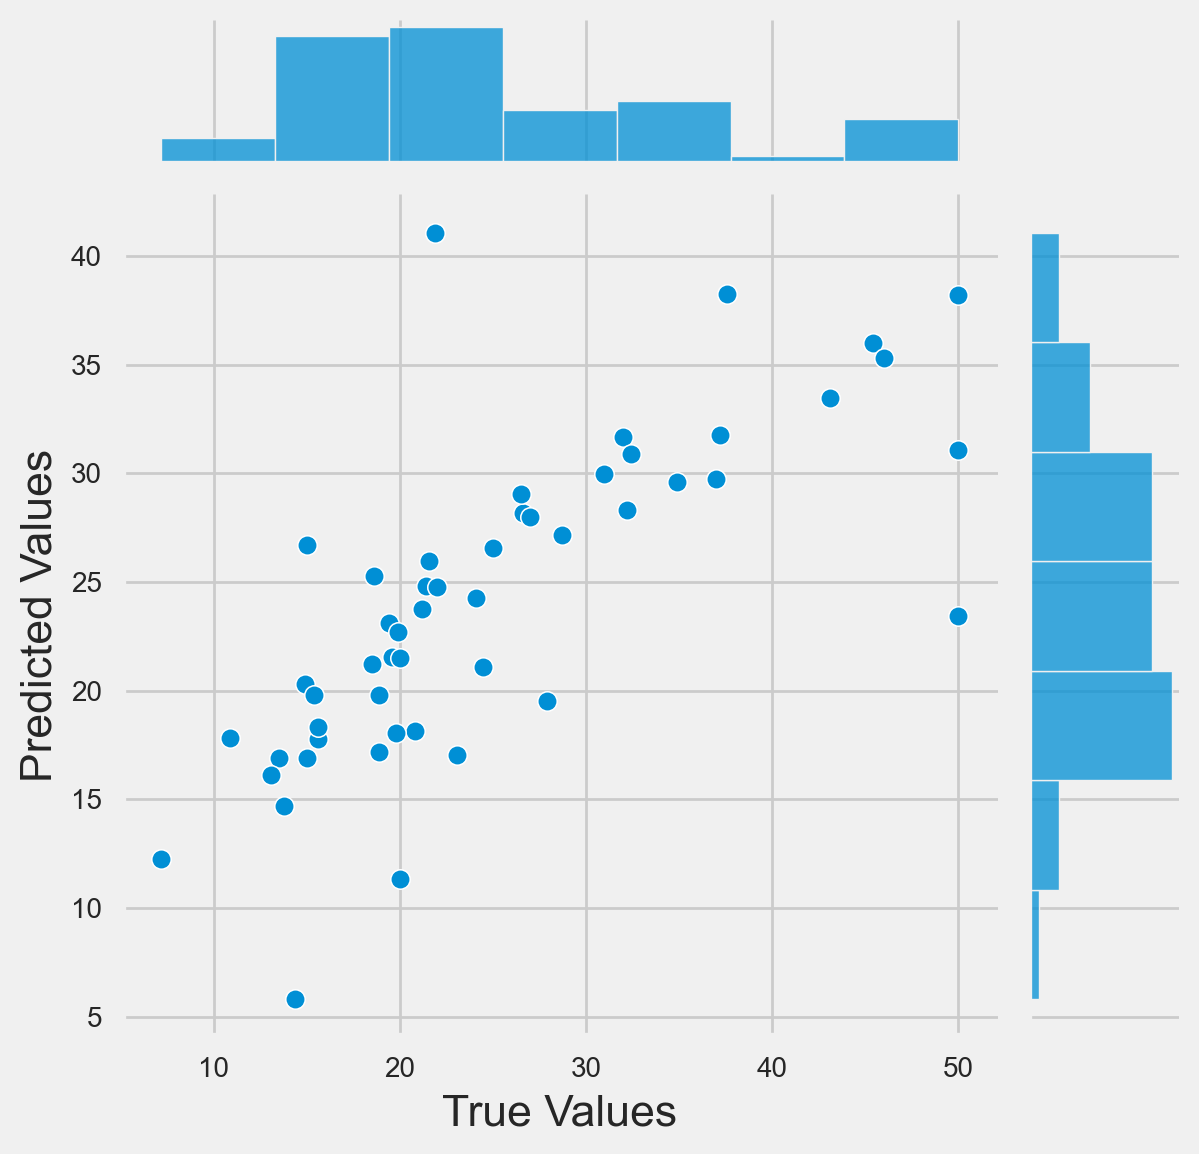

In [21]:
# Generate predictions.
y_pred = model.predict(X_test)

#plot y_predict vs y_test (your y true values)
sns.jointplot(x=y_test, y=y_pred)
plt.ylabel('Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 16);

C:\Users\Wes\mambaforge\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


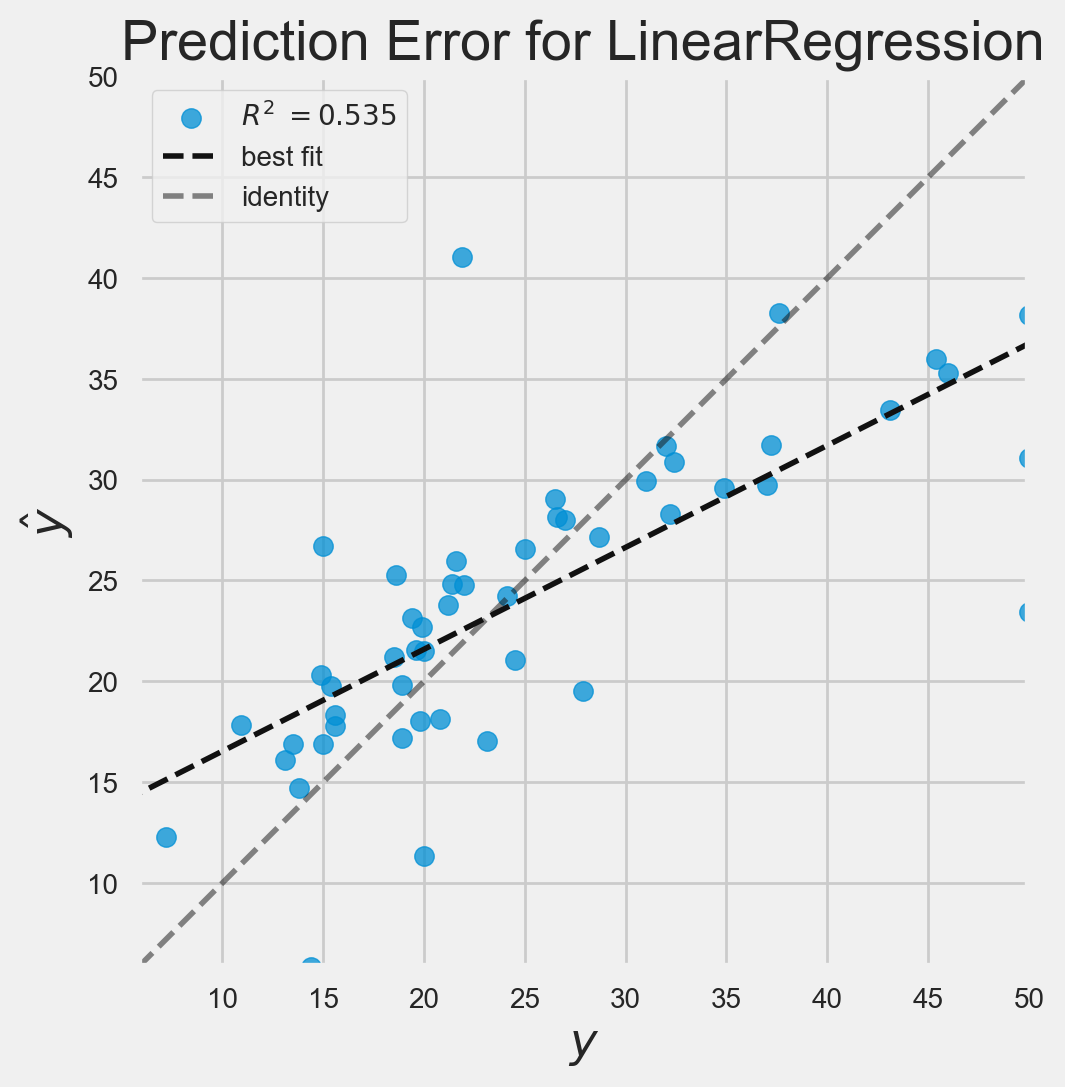

In [22]:
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof();

**Comment here**<br>

Using 90% of the data to train our model has not improved it at all. We have a worse model than the 70/30 split as we have approximately the same variance (as measured on the test set) but with even more bias (as indicated by the lower R2 on the train set)

### 4. Try K-Folds cross-validation with K between 5-10 for your regression. 

- What seems optimal? 
- How do your scores change?  
- What the variance of scores like?
- Try different folds to get a sense of how this impacts your score.

#### I will use a 50/50 train/test split to cross validate on

In [23]:
#Train-test-split with 50/50 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [24]:
# Instantiate/Fit Model
lr = LinearRegression()
# Cross validtion for 5 to 10 folds
for i in range(5,11):
    print(f"For {i}-fold cross validation, the mean cross_val_score is {cross_val_score(lr, X_train, y_train, cv=i, scoring = 'r2').mean()} and the variance is {cross_val_score(lr, X_train, y_train, cv=i, scoring = 'r2').var()}")

For 5-fold cross validation, the mean cross_val_score is 0.6645183815163347 and the variance is 0.002407340376730762
For 6-fold cross validation, the mean cross_val_score is 0.6510257141052095 and the variance is 0.005249522304635999
For 7-fold cross validation, the mean cross_val_score is 0.6569464442259699 and the variance is 0.006725327770768432
For 8-fold cross validation, the mean cross_val_score is 0.6476718284636993 and the variance is 0.010197688194671777
For 9-fold cross validation, the mean cross_val_score is 0.6491219527309819 and the variance is 0.012800655121139589
For 10-fold cross validation, the mean cross_val_score is 0.6589535758734797 and the variance is 0.014005016567594498


In [25]:
# Fit the model on the training data.
lr.fit(X_train, y_train)
# Compare with the training set without cross-validation
print(f'The R^2 for the training set with a 50/50 train-test split is: {model.score(X_train, y_train)}')
# Score on the test set
print(f'The R^2 for the test set with a 50/50 train-test split is: {model.score(X_test, y_test)}')


The R^2 for the training set with a 50/50 train-test split is: 0.6839893545954825
The R^2 for the test set with a 50/50 train-test split is: 0.6295009677009594


**Comment here**<br>
From our cross-validation results, 5-folds gives the model with the highest r2 and the lowest variance. Although the value of 0.664 is lower than the score of 0.683 using a 50/50 train test split, this cross validation score (r2) of our model is at best an optimistic estimate of its performance on the test set and compares rather favourably to our test scores, at least compared to the other cross-validated models below.

In any case, our test set can be considered our holdout set and gives us the final estimate of the machine learning model’s performance after it has been trained and validated.

#### I will use a 70/30 train/test split to cross validate on

In [26]:
#Train-test-split with 70/30 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [27]:
# Instantiate/Fit Model
lr = LinearRegression()
# Cross validtion for 5 to 10 folds
for i in range(5,11):
    print(f"For {i}-fold cross validation, the mean cross_val_score is {cross_val_score(lr, X_train, y_train, cv=i, scoring = 'r2').mean()} and the variance is {cross_val_score(lr, X_train, y_train, cv=i, scoring = 'r2').var()}")

For 5-fold cross validation, the mean cross_val_score is 0.6838448121637148 and the variance is 0.0005148808010775011
For 6-fold cross validation, the mean cross_val_score is 0.6879698414477794 and the variance is 0.0013325676495135818
For 7-fold cross validation, the mean cross_val_score is 0.6833854887500969 and the variance is 0.0034914825991042247
For 8-fold cross validation, the mean cross_val_score is 0.6900828762503648 and the variance is 0.003404207945069686
For 9-fold cross validation, the mean cross_val_score is 0.6562777706582336 and the variance is 0.010528873685809436
For 10-fold cross validation, the mean cross_val_score is 0.6771975064754759 and the variance is 0.0059378674938134635


In [28]:
# Fit the model on the training data.
lr.fit(X_train, y_train)
# Compare with the training set without cross-validation
print(f'The R^2 for the training set with a 70/30 train-test split is: {model.score(X_train, y_train)}')
# Score on the test set
print(f'The R^2 for the test set with a 70/30 train-test split is: {model.score(X_test, y_test)}')

The R^2 for the training set with a 70/30 train-test split is: 0.6993880263112933
The R^2 for the test set with a 70/30 train-test split is: 0.5503921652012995


**Comment here**<br>
I would pick the folds with the lowest variance and in this case, would be for 5-folds cross validation. The score of 0.683 compares favourably to the score of 0.699 on the training set without cross-validation. Unfortunately, the model's performance on the test set is much worse, with a score of 0.550. The difference in cross val score and test scores suggest our model is overfit to the training data, either that or these is some sort of sampling error.

#### I will use a 90/10 train/test split to cross validate on

In [29]:
#Train-test-split with 90/10 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [30]:
# Instantiate/Fit Model
lr = LinearRegression()
# Cross validtion for 5 to 10 folds
for i in range(5,11):
    print(f"For {i}-fold cross validation, the mean cross_val_score is {cross_val_score(lr, X_train, y_train, cv=i, scoring = 'r2').mean()} and the variance is {cross_val_score(lr, X_train, y_train, cv=i, scoring = 'r2').var()}")

For 5-fold cross validation, the mean cross_val_score is 0.6378645684320662 and the variance is 0.010385977996649531
For 6-fold cross validation, the mean cross_val_score is 0.6537077600267841 and the variance is 0.007179798720535514
For 7-fold cross validation, the mean cross_val_score is 0.6504898218781585 and the variance is 0.008330361264558578
For 8-fold cross validation, the mean cross_val_score is 0.6454122790352238 and the variance is 0.012015446437729546
For 9-fold cross validation, the mean cross_val_score is 0.6360923053725218 and the variance is 0.012590408861485618
For 10-fold cross validation, the mean cross_val_score is 0.6335100783700149 and the variance is 0.016785533718681397


In [31]:
# Fit the model on the training data.
lr.fit(X_train, y_train)
# Compare with the training set without cross-validation
print(f'The R^2 for the training set with a 90/10 train-test split is: {model.score(X_train, y_train)}')
# Score on the test set
print(f'The R^2 for the test set with a 90/10 train-test split is: {model.score(X_test, y_test)}')

The R^2 for the training set with a 90/10 train-test split is: 0.6730466768334123
The R^2 for the test set with a 90/10 train-test split is: 0.5346268695101035


**Comment here**<br>
Cross validating on a 90/10 train-test split with 5 to 11 folds does not give a model with as good results as the other 2 train-test splits. Firstly, the cross-val score is the lowest among the 3 splits (50/50, 70/30 and 90/10). Secondly, the score for the test set is also the lowest among the 3 splits. 

My conclusion is that I would use the 50/50 train test split and holdout 50% of my data. The cross-validation scores on the remaining 50% of the training set compare favourably to the holdout set and gives the sweet spot of model bias and variance, at least for this type of model architecture and with these features.

## Creating a model with polynomial features (Just for fun)

In [32]:
#Train-test-split with 90/10 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [33]:
# Create a model using 2 polynomial features
poly = PolynomialFeatures(2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train,y_train)

print(f'The R2 for the train set is: {poly_reg.score(X_poly_train, y_train)}')
print(f"The R2 on the cross-val data is: {cross_val_score(poly_reg, X_poly_train, y_train, cv=5, scoring = 'r2').mean()}")
print(f'The R2 on the test data is: {poly_reg.score(X_poly_test, y_test)}')


The R2 for the train set is: 0.8430066167605954
The R2 on the cross-val data is: 0.7813163732831825
The R2 on the test data is: 0.7516012928433584


**Comment here**<br>

From the scores of our polynomial model, we have a much better model! Our cross-val score of 0.781 and our test score of 0.751 is better than for a purely linear model. Earlier I did mention that a purely linear model would not be able to generalise well to some of our chosen features (CRIM and DIS, due to poor correlation scores with our target MEDV). Our polynomial model definitely is overfit as seen by the difference in train and test scores, but I believe this is a better model to predict MEDV from our boston housing data, since our model already has better scores compared to the 'vanilla' linear regression without any form of tuning.

### 5. [Bonus] optimize the $R^2$ score

Can you optimize your R^2 by selecting the best features and validating the model using either train/test split or K-Folds?

Your code will need to iterate through the different combinations of predictors, cross-validate the current model parameterization, and determine which set of features performed best.

The number of K-folds is up to you.

> *Hint:* the `itertools` package is useful for combinations and permutations.


In [34]:
# Create a list of columns from our boston housing dataframe
col_list = list(df.columns)
# Remove our target column
col_list.remove('MEDV')
# I want every combination of 4 features without replacement
tuples_of_four_combinations = combinations(col_list, 4)
# Create our target series
y = df['MEDV']

In [35]:
# Create the necessary variables for our for loop
best_cross_val_score = 0
best_cross_val_score_features = ""
best_test_score = 0
best_train_score = 0

# Iterate through every combination of 4 features
for tuple in tuples_of_four_combinations:
    # Create a feature matrix 
    X = df[list(tuple)]
    # Split our features and target into train/test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    # Instantiate our model
    lr = LinearRegression()
    # Fit the model on the training data
    lr.fit(X_train, y_train)
    # Cross validate with 5 folds and assign the mean of scores to val_score
    val_score = cross_val_score(lr, X_train, y_train, cv=5, scoring = 'r2').mean()
    # Score our model on our test set and assign this to test_score
    test_score = lr.score(X_test, y_test)
    # Score our model on our train set and assign this to train_score
    train_score = lr.score(X_train, y_train)
    # If this cross_val_score is better than our current best_cross_val_score, reassign best_cross_val_score, 
    # and assign that combination of features to best_cross_val_score_features
    if val_score > best_cross_val_score:
        best_cross_val_score = val_score
        best_cross_val_score_features = tuple
        best_test_score = test_score
        best_train_score = train_score

In [36]:
# For any combination of 4 features, print out the best scores and the features associated with that score
print(f'Test score: {best_test_score}')
print(f'Train score: {best_train_score}')
print(f'Cross validated score: {best_cross_val_score}')
print(best_cross_val_score_features)

Test score: 0.5696370002252786
Train score: 0.734789077695053
Cross validated score: 0.7188471816378609
('RM', 'DIS', 'PTRATIO', 'LSTAT')


**Comment here**<br>
Using four features, the best score on the test set is 0.569 with the features 'RM', 'DIS', 'PTRATIO', 'LSTAT', while the best cross validated score is 0.718 with these features and the best train score is 0.734. This model suffers from overfit as reflected by the difference between test (holdout) and train scores. The large difference between cross validated scores and the test scores indicate some issue with the sampling. Note that the model chosen was optimised for cross-validated score.


In [37]:
# Create the necessary variables for our for loop
best_cross_val_score = 0
best_cross_val_score_features = ""
best_test_score = 0
best_train_score = 0

# This for loop does the same as the loop for 4 features, but iterates through every combination of 1 to 10 features
# and assigns the best combination of features to best_cross_val_score_features and the best scores to best_test_score,
# best_train_score and best_cross_val_score
for i in range(1, 11):
    tuple_combination = combinations(col_list, i)
    for tuple in tuple_combination:
        X = df[list(tuple)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        val_score = cross_val_score(lr, X_train, y_train, cv=5, scoring = 'r2').mean()
        test_score = lr.score(X_test, y_test)
        train_score = lr.score(X_train, y_train)
        if val_score > best_cross_val_score:
            best_cross_val_score = val_score
            best_cross_val_score_features = tuple
            best_test_score = test_score
            best_train_score = train_score

In [38]:
# For any combination of 1 to 10 features, print out the best scores and the features associated with those scores
print(f'Test score: {best_test_score}')
print(f'Train score: {best_train_score}')
print(f'Cross validated score: {best_cross_val_score}')
print(best_cross_val_score_features)

Test score: 0.6481586799026388
Train score: 0.7637550521778602
Cross validated score: 0.7408207759376764
('CRIM', 'ZN', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT')


**Comment here**<br>

Using any combination of 1 to 10 features, the best score on the test set is 0.648 with the features 'CRIM', 'ZN', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', while the best cross validated score with these features is 0.740 and the best train score is 0.763. There is some improvement compared to the model fitted with 4 features as reflected in the higher scores across the board. Note that the model chosen was optimised for cross-validated score.


In [39]:
# Create the necessary variables for our for loop
best_cross_val_score = 0
best_cross_val_score_features = ""
best_test_score = 0
best_train_score = 0

# This for loop does the same as the for loop for 1 to 10 features, but fits the features on a 2nd degree polynomial linear regressor
for i in range(1, 11):
    tuple_combination = combinations(col_list, i)
    for tuple in tuple_combination:
        X = df[list(tuple)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)
        poly = PolynomialFeatures(2, include_bias=False)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.fit_transform(X_test)
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train,y_train)
        val_score = cross_val_score(poly_reg, X_poly_train, y_train, cv=5, scoring = 'r2').mean()
        test_score = poly_reg.score(X_poly_test, y_test)
        train_score = poly_reg.score(X_poly_train, y_train)
        if val_score > best_cross_val_score:
            best_cross_val_score = val_score
            best_cross_val_score_features = tuple
            best_test_score = test_score
            best_train_score = train_score


In [40]:
# For any combination of 1 to 10 features, print out the best scores and the features associated with those scores
print(f'Test score: {best_test_score}')
print(f'Train score: {best_train_score}')
print(f'Cross validated score: {best_cross_val_score}')
print(best_cross_val_score_features)

Test score: 0.7874695057396701
Train score: 0.9063179964305896
Cross validated score: 0.8582808025607683
('CRIM', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT')


**Comment here**<br>

Using any combination of 1 to 10 features, the best score on the test set is 0.787 with the features 'CRIM', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', while the best cross validated score with these features is 0.858 and the best train score is 0.906. Surprisingly, the best model obtained used only 7 out of 10 available features. This model performed the best amongst all the models predicting MEDV from a given set of features. Note that the model chosen was optimised for cross-validated score. 

### 5.1 Can you explain what could be wrong with this approach?

Even without the comments below, this method seems like p-hacking or data-mining, where we are trying to create the 'best' model and then making the spurious conclusion that what we have discovered is anything but random.

In [41]:
# Even though we are cross-validating to get our R2 score for each model we're testing, 
# we're trying thousands of different models and then choosing the one that has the
# absolute highest R2.
# Cross-validation does not eliminate the fact that this is a random sample from an
# overall population, and the highest R2 out of these models is likely going to be 
# higher than the ones near it by chance. Is the model with the best R2 *REALLY* 
# better than the 2nd highest? 3rd highest?

# This is an important point: you are the researcher and you should, whenever possible,
# NOT rely on the computer's "brute force". This is why EDA is so important as well
# as domain knowledge. As a human being can we eliminate variables that we know 
# should not be used to build the model?

### 6. [Bonus] Explore another target variable and practice `patsy` formulas

Can you find another response variable, given a combination of predictors, that can be predicted accurately through the exploration of different predictors in this dataset?

**Try out using patsy to construct your target and predictor matrices from formula strings.**

> *Tip: Check out pairplots, coefficients, and pearson scores.*

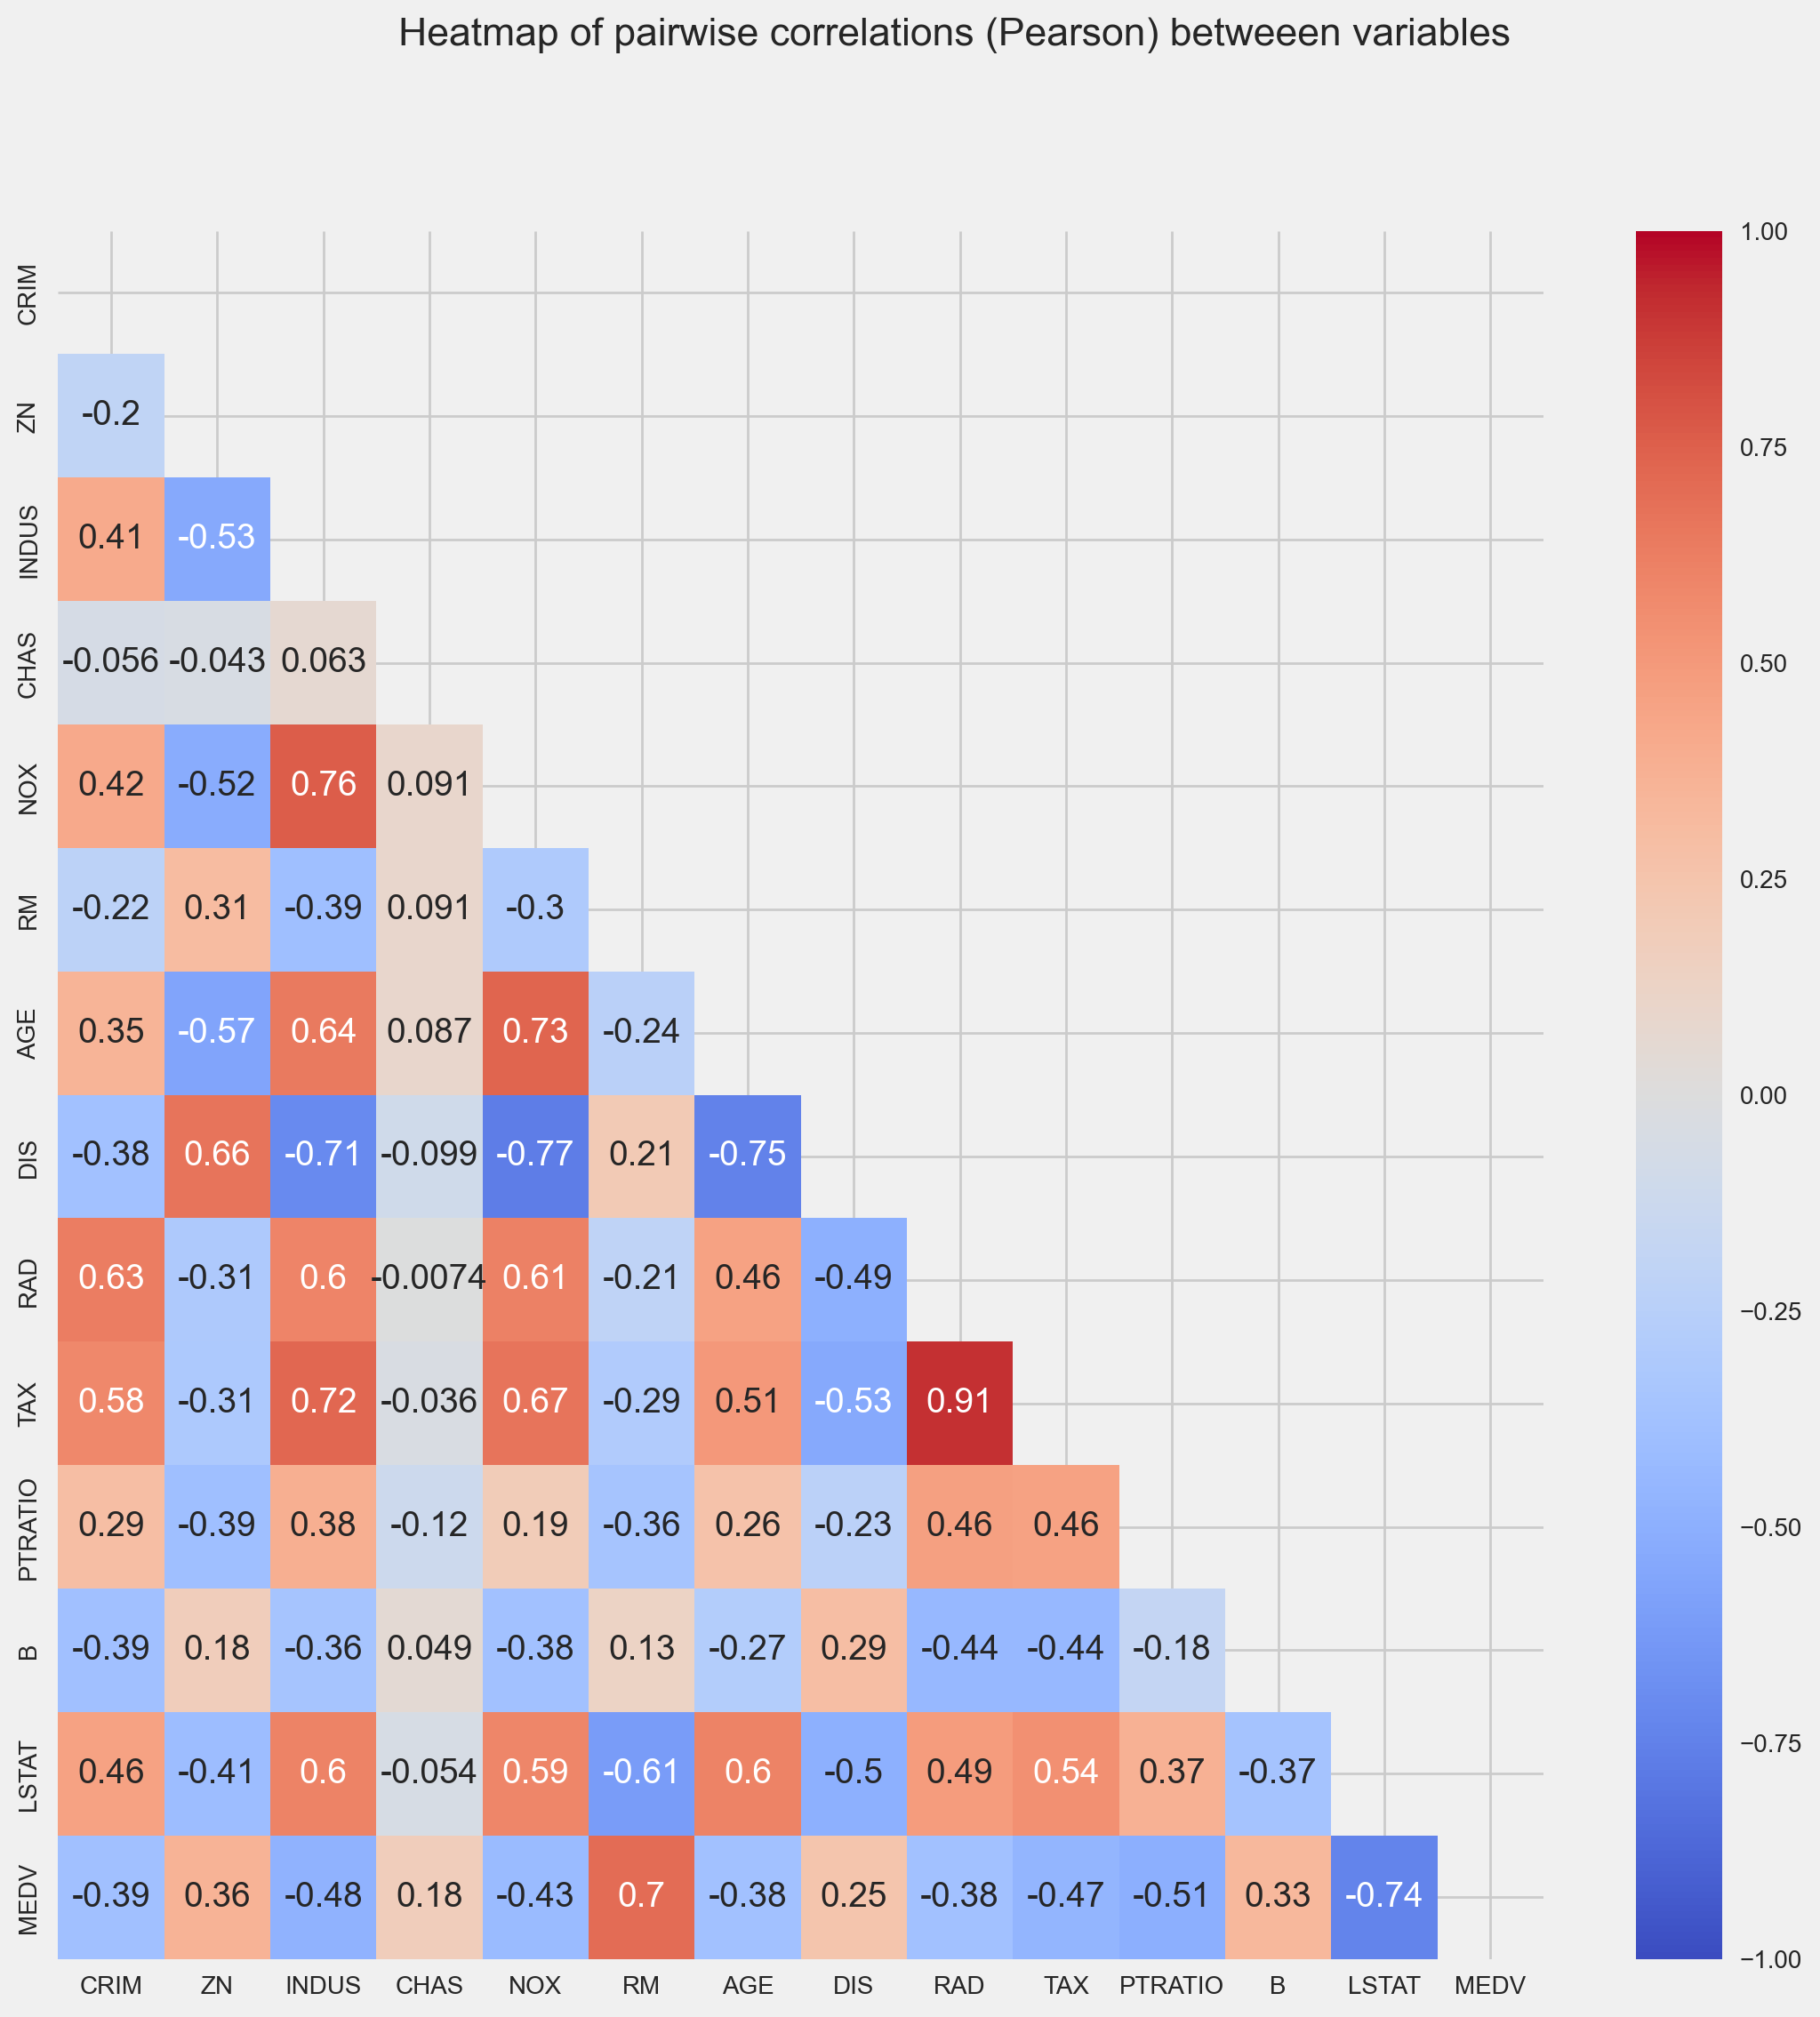

In [42]:
#Create a correlation heatmap 
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(df.corr(numeric_only=True)))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.suptitle('Heatmap of pairwise correlations (Pearson) betweeen variables', fontsize=16);

**Comment here**<br>
Using pairplot and a correlation heatmap, I have tentatively chosen 'TAX' to be our new target. I prefer 'TAX' over 'RAD' since RAD is more like a categorical value (after checking unique values). I will chose the features with the highest correlation values against 'TAX' as the features for inputs into our model.

In [43]:
new_target = ""
best_score = 0
# iterate through all features and find the highest correlation value and the corresponding index
for i in df.columns:
    data = df.corr()[[i]].sort_values(i, ascending=False).values[1:5].squeeze()
    index = df.corr()[[i]].sort_values(i, ascending=False).index[1:5]
    for index, value in zip(index, data):
        if value > best_score:
            best_score = value
            new_target = index
            
print(new_target, best_score)

TAX 0.9102281885331865


In [44]:
# Highest 4 correlation values
print(df.corr()[['TAX']].sort_values('TAX', ascending=False).iloc[1:5])
# Lowest 4 correlation values
print(df.corr()[['TAX']].sort_values('TAX', ascending=False).iloc[-4:])

            TAX
RAD    0.910228
INDUS  0.720760
NOX    0.668023
CRIM   0.582764
           TAX
ZN   -0.314563
B    -0.441808
MEDV -0.468536
DIS  -0.534432


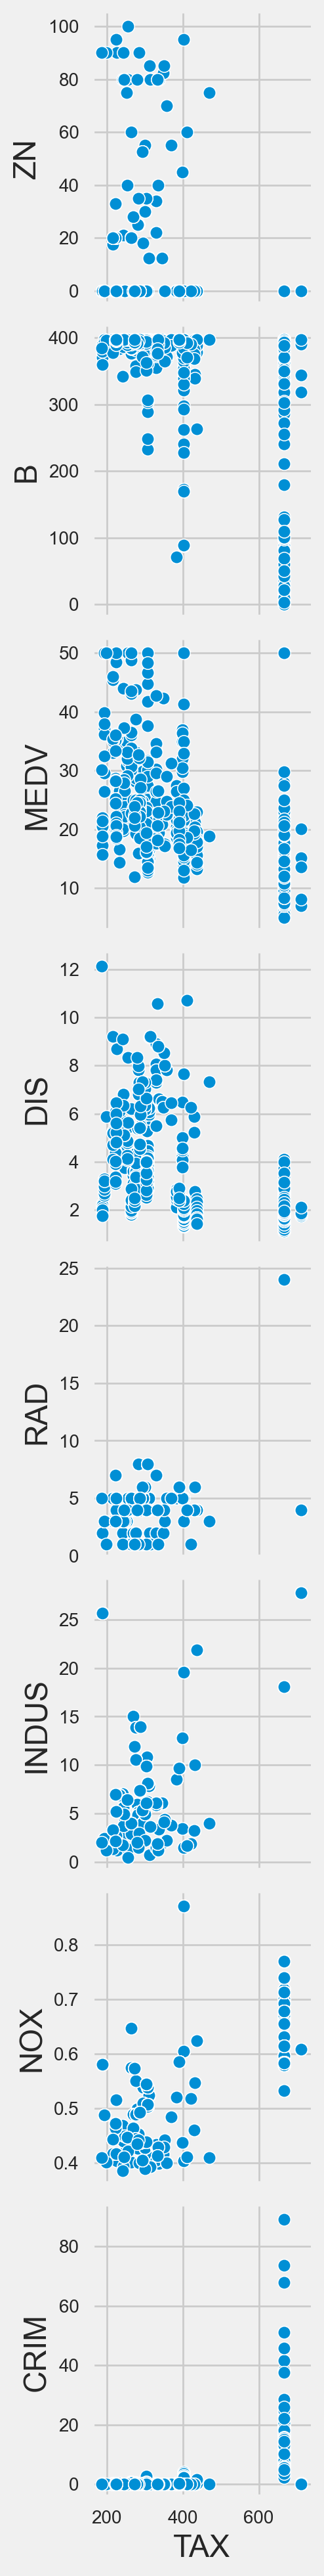

In [45]:
# Create a pairplot of 'TAX' against our 8 features
sns.pairplot(df, y_vars=['ZN', 'B', 'MEDV', 'DIS', 'RAD', 'INDUS', 'NOX', 'CRIM'], x_vars =['TAX']);

In [46]:
# Choose the 8 best most correlated features and create a 2-way interaction between all chosen features
formula = '(ZN + B + MEDV + DIS + RAD + INDUS + NOX + CRIM) **2 -1'
# Create our features dataframe
X = patsy.dmatrix(formula, df, return_type='dataframe')
# Create our target series
y = df['TAX']

In [47]:
#Train-test-split with 90/10 train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [48]:
# Instantiate the model.
model = LinearRegression()
# Fit the model on the training data.
model.fit(X_train, y_train)
# Score on our train set
print(model.score(X_train, y_train))
# Score on our test set
print(model.score(X_test, y_test))

0.9050764132784818
0.9379041225185331


In [49]:
# Cross validated score
cross_val_score(model, X_train, y_train, cv=5, scoring = 'r2').mean()

0.8898349269747129

**Comment here**<br>
We created a model that has a much better score, but predicting for 'TAX' instead of 'MEDV'. The scores are 0.889 for the cross val score, 0.905 for the train score and 0.937 for the test (hold-out) set. In fact, the model performs better on the test set than on the train set.